# GAN Trained on MNIST with CNN layers

## Imports

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [2]:
from helper_data import get_dataloaders_mnist
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0005
DISCRIMINATOR_LEARNING_RATE = 0.0005

NUM_EPOCHS = 80
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [5]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [6]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


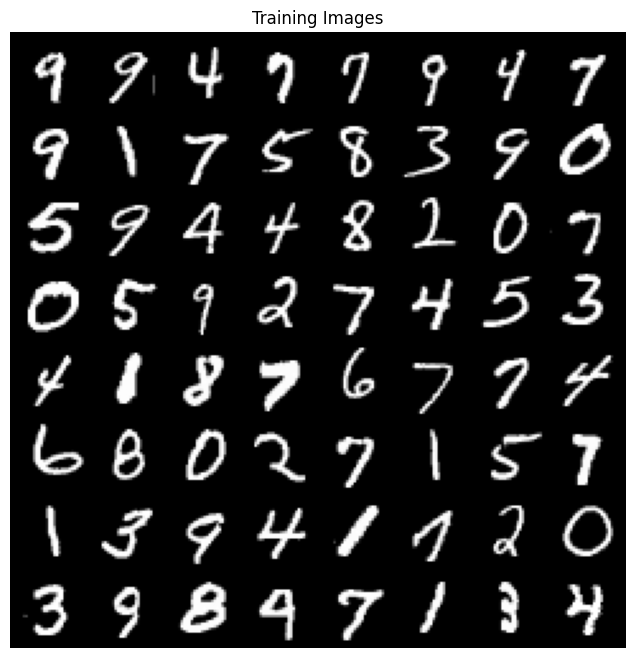

In [7]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

## Model

In [8]:
##########################
### MODEL
##########################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)
    
    
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super(GAN, self).__init__()
        
#         self.image_height = image_height
#         self.image_width = image_width
#         self.color_channels = color_channels
        
        self.generator = nn.Sequential(
              
            nn.Linear(latent_dim, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            
#             nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
#             nn.BatchNorm2d(num_features=32),
#             nn.LeakyReLU(inplace=True, negative_slope=0.0001),            
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),

#             nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(num_features=8),
#             nn.LeakyReLU(inplace=True, negative_slope=0.0001),
                        
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            
            nn.Conv2d(in_channels=16, out_channels=16, padding=1, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            
#             nn.Conv2d(in_channels=16, out_channels=16, padding=1, kernel_size=(3, 3), stride=(1, 1), bias=False),
#             nn.BatchNorm2d(num_features=16),
#             nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            
            nn.Conv2d(in_channels=16, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            
#             nn.Conv2d(in_channels=32, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
#             nn.BatchNorm2d(num_features=32),
#             nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            
            
#             nn.Conv2d(in_channels=32, out_channels=64, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
#             nn.BatchNorm2d(num_features=64),
#             nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
#         z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
#         img = img.view(z.size(0),
#                        self.color_channels,
#                        self.image_height,
#                        self.image_width)
        return img
        


    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits.view(-1)

In [9]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [10]:
print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 

## Training

In [11]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/080 | Batch 000/469 | Gen/Dis Loss: 0.8546/0.7364
Epoch: 001/080 | Batch 100/469 | Gen/Dis Loss: 1.7843/0.2523
Epoch: 001/080 | Batch 200/469 | Gen/Dis Loss: 2.4960/0.2912
Epoch: 001/080 | Batch 300/469 | Gen/Dis Loss: 1.5849/0.4610
Epoch: 001/080 | Batch 400/469 | Gen/Dis Loss: 0.9583/0.4333
Time elapsed: 0.48 min
Epoch: 002/080 | Batch 000/469 | Gen/Dis Loss: 1.5016/0.3647
Epoch: 002/080 | Batch 100/469 | Gen/Dis Loss: 1.3949/0.3750
Epoch: 002/080 | Batch 200/469 | Gen/Dis Loss: 1.3682/0.3467
Epoch: 002/080 | Batch 300/469 | Gen/Dis Loss: 2.2976/0.4382
Epoch: 002/080 | Batch 400/469 | Gen/Dis Loss: 0.9105/0.4520
Time elapsed: 0.81 min
Epoch: 003/080 | Batch 000/469 | Gen/Dis Loss: 1.4322/0.4053
Epoch: 003/080 | Batch 100/469 | Gen/Dis Loss: 1.2861/0.4633
Epoch: 003/080 | Batch 200/469 | Gen/Dis Loss: 1.5750/0.3466
Epoch: 003/080 | Batch 300/469 | Gen/Dis Loss: 2.0133/0.3492
Epoch: 003/080 | Batch 400/469 | Gen/Dis Loss: 1.5022/0.3973
Time elapsed: 1.15 min
Epoch: 004/080 |

Epoch: 026/080 | Batch 100/469 | Gen/Dis Loss: 1.2606/0.4653
Epoch: 026/080 | Batch 200/469 | Gen/Dis Loss: 1.2939/0.4947
Epoch: 026/080 | Batch 300/469 | Gen/Dis Loss: 1.0254/0.4988
Epoch: 026/080 | Batch 400/469 | Gen/Dis Loss: 1.3652/0.5318
Time elapsed: 9.19 min
Epoch: 027/080 | Batch 000/469 | Gen/Dis Loss: 0.9925/0.5415
Epoch: 027/080 | Batch 100/469 | Gen/Dis Loss: 1.2433/0.5167
Epoch: 027/080 | Batch 200/469 | Gen/Dis Loss: 1.5954/0.5865
Epoch: 027/080 | Batch 300/469 | Gen/Dis Loss: 0.9862/0.5246
Epoch: 027/080 | Batch 400/469 | Gen/Dis Loss: 1.2692/0.5563
Time elapsed: 9.52 min
Epoch: 028/080 | Batch 000/469 | Gen/Dis Loss: 0.6027/0.5892
Epoch: 028/080 | Batch 100/469 | Gen/Dis Loss: 1.6281/0.5249
Epoch: 028/080 | Batch 200/469 | Gen/Dis Loss: 0.9765/0.4802
Epoch: 028/080 | Batch 300/469 | Gen/Dis Loss: 1.4788/0.5178
Epoch: 028/080 | Batch 400/469 | Gen/Dis Loss: 0.9875/0.5729
Time elapsed: 9.86 min
Epoch: 029/080 | Batch 000/469 | Gen/Dis Loss: 1.0643/0.5277
Epoch: 029/080 |

Epoch: 051/080 | Batch 100/469 | Gen/Dis Loss: 1.4035/0.5896
Epoch: 051/080 | Batch 200/469 | Gen/Dis Loss: 1.0978/0.5116
Epoch: 051/080 | Batch 300/469 | Gen/Dis Loss: 0.8947/0.5505
Epoch: 051/080 | Batch 400/469 | Gen/Dis Loss: 1.4886/0.5804
Time elapsed: 17.91 min
Epoch: 052/080 | Batch 000/469 | Gen/Dis Loss: 1.6812/0.5703
Epoch: 052/080 | Batch 100/469 | Gen/Dis Loss: 0.8990/0.6056
Epoch: 052/080 | Batch 200/469 | Gen/Dis Loss: 1.0496/0.5413
Epoch: 052/080 | Batch 300/469 | Gen/Dis Loss: 1.0961/0.5786
Epoch: 052/080 | Batch 400/469 | Gen/Dis Loss: 0.9799/0.5485
Time elapsed: 18.29 min
Epoch: 053/080 | Batch 000/469 | Gen/Dis Loss: 1.1910/0.5159
Epoch: 053/080 | Batch 100/469 | Gen/Dis Loss: 0.9004/0.6506
Epoch: 053/080 | Batch 200/469 | Gen/Dis Loss: 0.9738/0.6026
Epoch: 053/080 | Batch 300/469 | Gen/Dis Loss: 1.4584/0.5689
Epoch: 053/080 | Batch 400/469 | Gen/Dis Loss: 0.7180/0.6182
Time elapsed: 18.64 min
Epoch: 054/080 | Batch 000/469 | Gen/Dis Loss: 0.8439/0.5562
Epoch: 054/08

Epoch: 076/080 | Batch 100/469 | Gen/Dis Loss: 1.5289/0.6234
Epoch: 076/080 | Batch 200/469 | Gen/Dis Loss: 0.5046/0.6823
Epoch: 076/080 | Batch 300/469 | Gen/Dis Loss: 1.2807/0.5306
Epoch: 076/080 | Batch 400/469 | Gen/Dis Loss: 0.9054/0.5966
Time elapsed: 26.66 min
Epoch: 077/080 | Batch 000/469 | Gen/Dis Loss: 1.3361/0.5477
Epoch: 077/080 | Batch 100/469 | Gen/Dis Loss: 0.8789/0.5839
Epoch: 077/080 | Batch 200/469 | Gen/Dis Loss: 1.0720/0.6055
Epoch: 077/080 | Batch 300/469 | Gen/Dis Loss: 1.2408/0.5600
Epoch: 077/080 | Batch 400/469 | Gen/Dis Loss: 1.3763/0.6236
Time elapsed: 27.01 min
Epoch: 078/080 | Batch 000/469 | Gen/Dis Loss: 1.2660/0.4985
Epoch: 078/080 | Batch 100/469 | Gen/Dis Loss: 1.0099/0.5543
Epoch: 078/080 | Batch 200/469 | Gen/Dis Loss: 1.0804/0.5935
Epoch: 078/080 | Batch 300/469 | Gen/Dis Loss: 1.2542/0.5894
Epoch: 078/080 | Batch 400/469 | Gen/Dis Loss: 1.0488/0.6649
Time elapsed: 27.35 min
Epoch: 079/080 | Batch 000/469 | Gen/Dis Loss: 0.6833/0.6274
Epoch: 079/08

## Evaluation

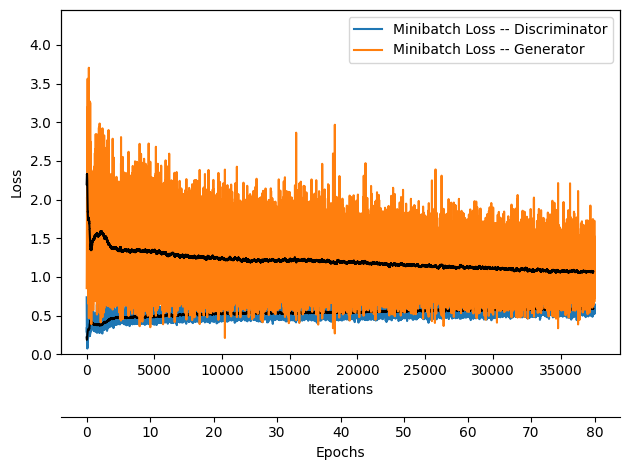

In [12]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

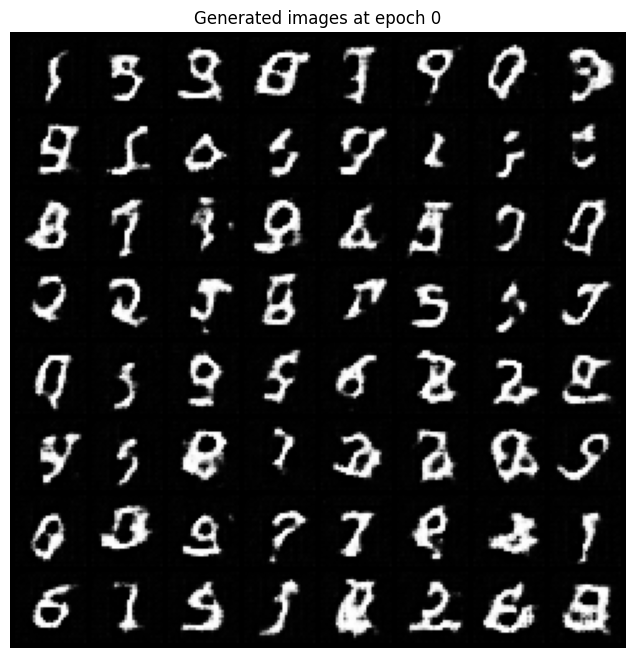

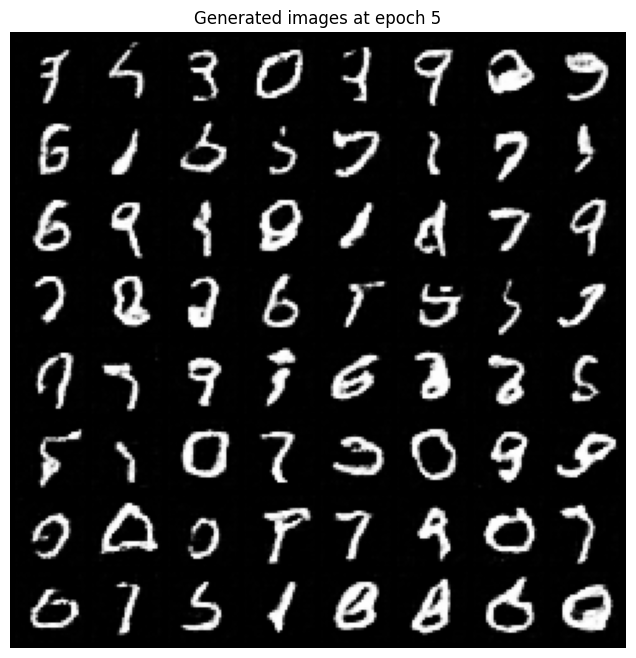

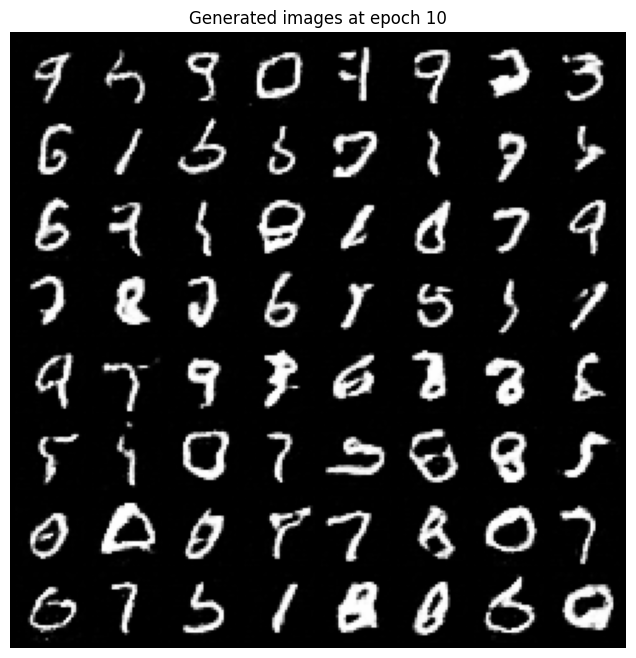

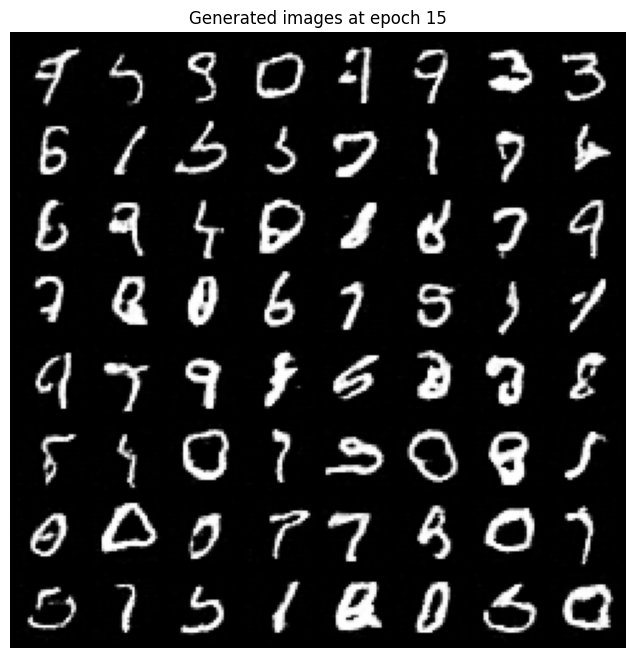

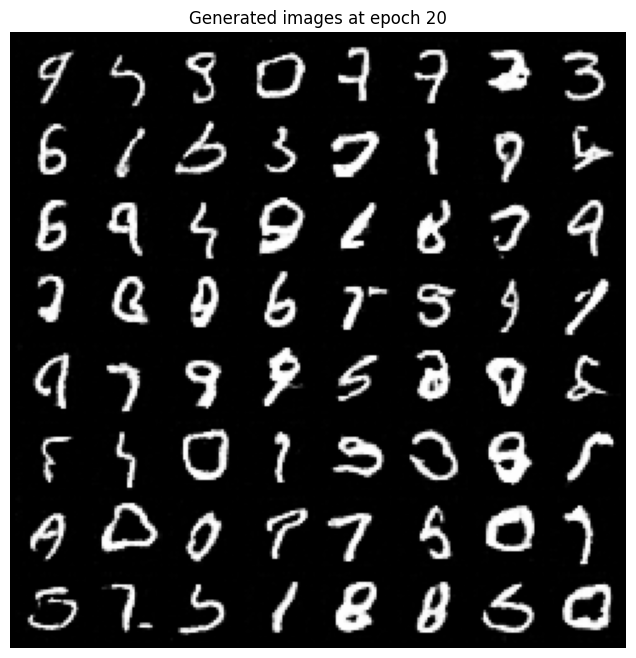

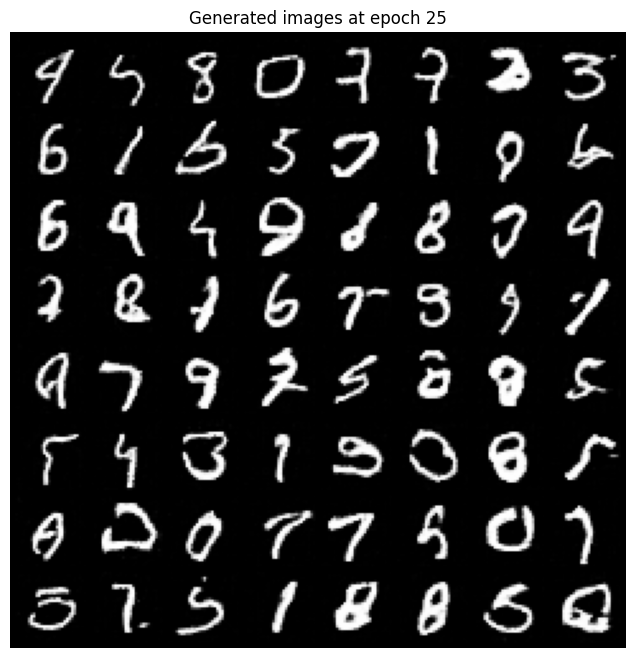

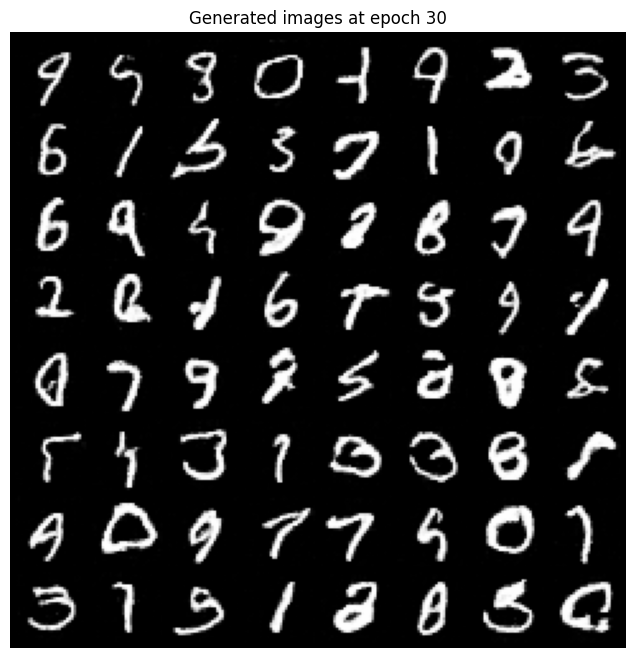

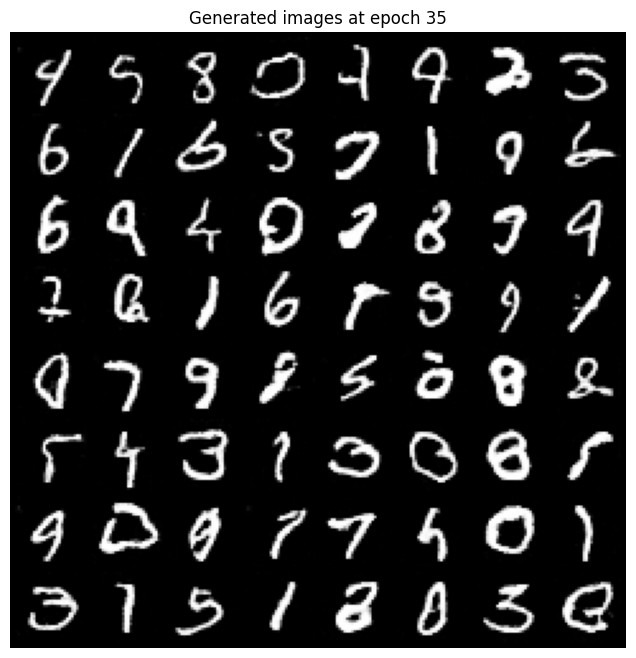

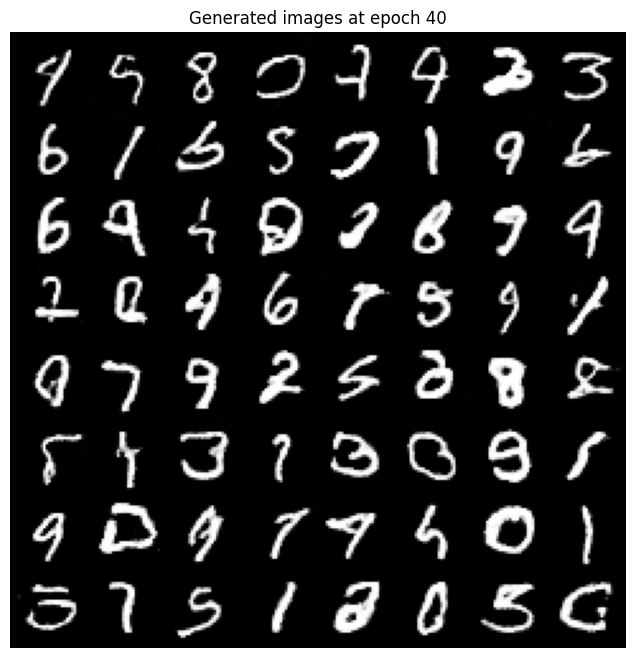

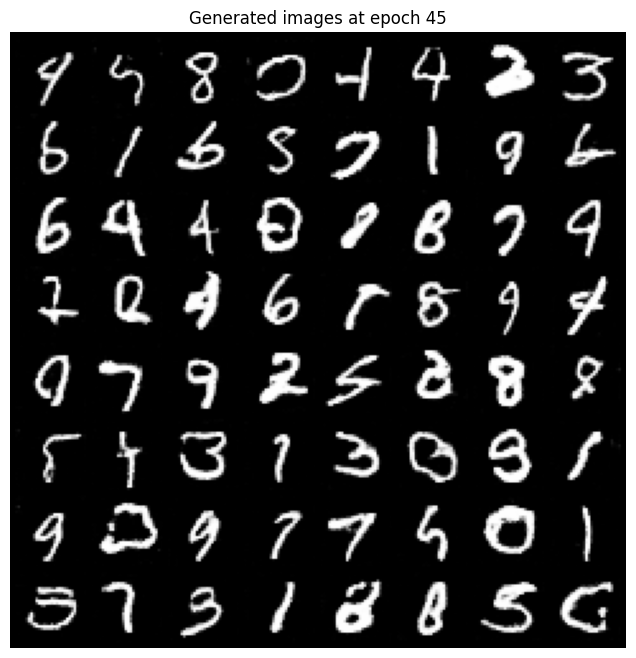

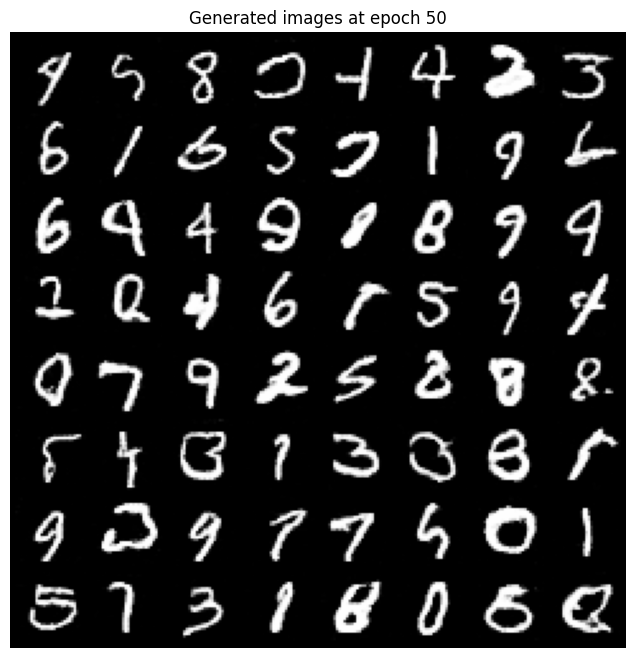

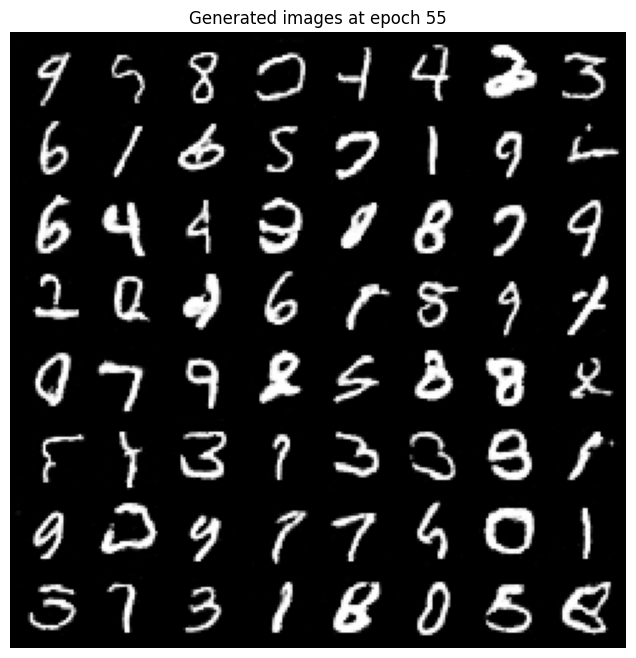

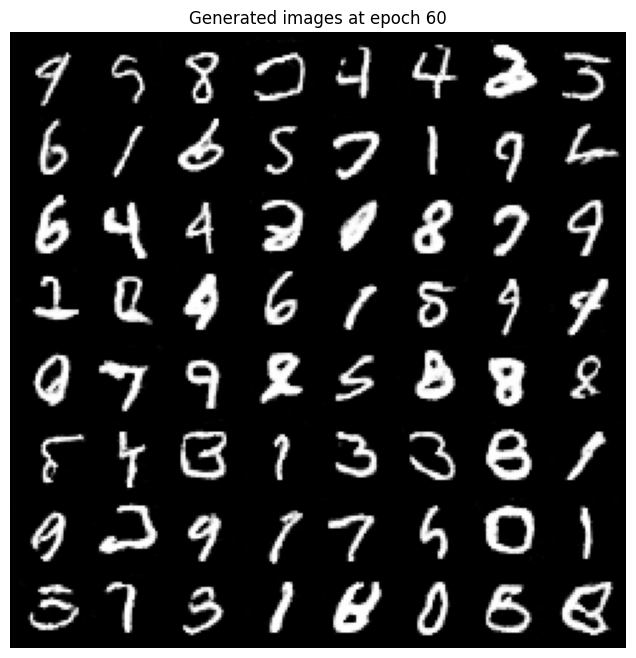

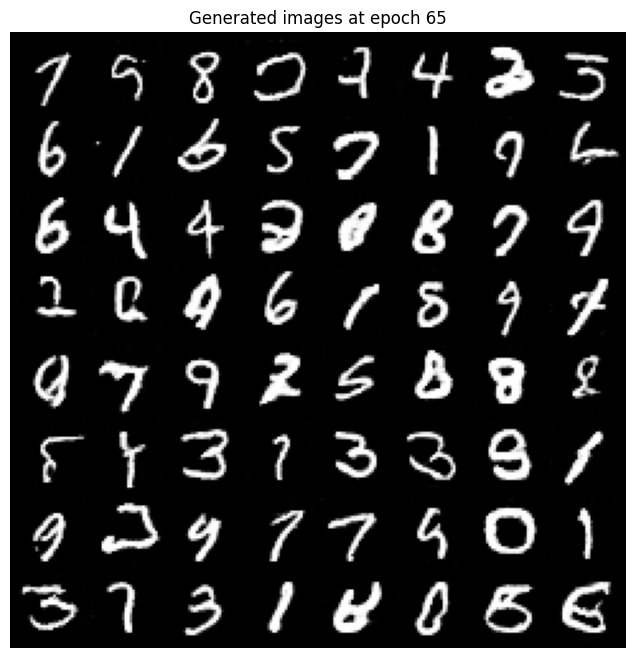

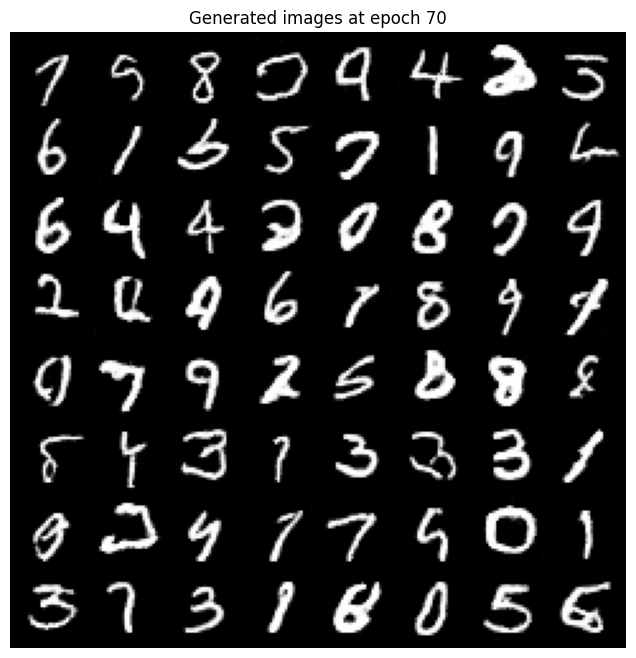

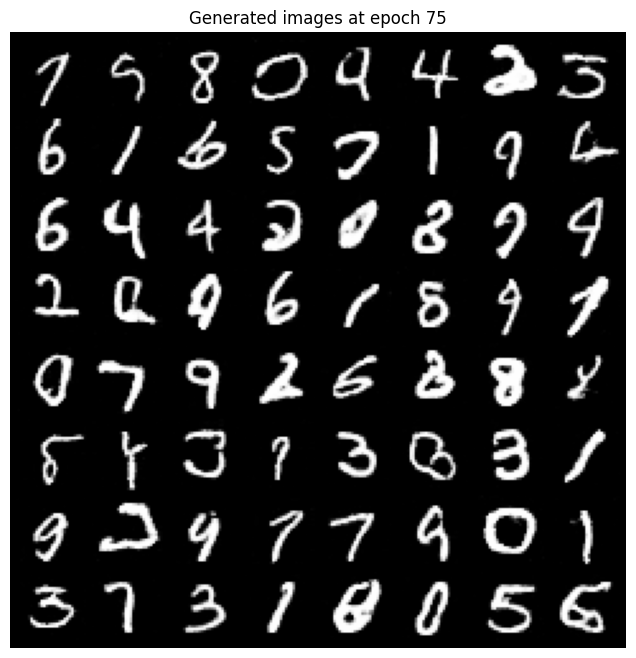

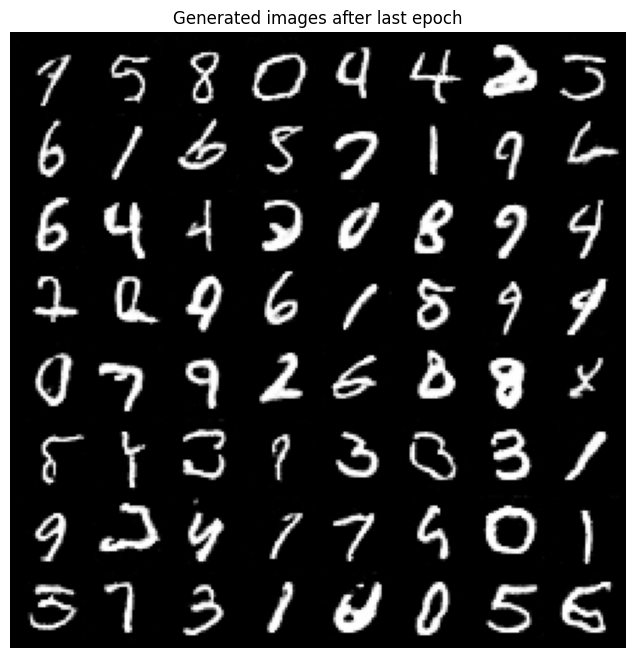

In [13]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()